# Dataset Preparation and Preprocessing for EMNIST Letters

In this notebook, we will download and preprocess the EMNIST Letters dataset. The dataset contains handwritten character images and their corresponding labels. We will extract the images and labels, normalize the data, and visualize some samples.

## Step 1: Install Required Libraries
First, we need to install the required libraries: `datasets`, `emnist`, `soundfile`, `tensorflowjs` and `scikit-learn`.

In [2]:
!pip install datasets
!pip install emnist
!pip install soundfile
!pip install tensorflowjs
!pip install scikit-learn

## Step 2: Import Libraries
We will import the necessary libraries for data handling, visualization, and interaction with Google Drive.

In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import tensorflowjs as tfjs
from datasets import load_dataset
import os
import shutil
import soundfile as sf
import matplotlib.pyplot as plt
import gzip
import struct
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Import Google Drive for file access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 3: List Files in Google Drive Directory
Next, we list the files in the Google Drive directory to ensure that the required .gz files are available.

In [2]:
drive_dir = '/content/drive/MyDrive/Colab-Notebooks/LexiLearn_Machine_Learning/data'
print(os.listdir(drive_dir))

['emnist-letters-test-images-idx3-ubyte.gz', 'emnist-letters-train-labels-idx1-ubyte.gz', 'emnist-letters-test-labels-idx1-ubyte.gz', 'gzip.zip', 'emnist-letters-train-images-idx3-ubyte.gz', 'emnist_letters_model.h5', 'cv-corpus-17.0-2024-03-15-id.tar.gz', 'emnist', 'processed']


## Step 4: Define Paths for the Dataset Files
We will define the paths for the training and testing image and label files in our Google Drive.


In [3]:
# Path to .gz files in Google Drive
drive_file_path_train_images = os.path.join(drive_dir, 'emnist-letters-train-images-idx3-ubyte.gz')
drive_file_path_train_labels = os.path.join(drive_dir, 'emnist-letters-train-labels-idx1-ubyte.gz')
drive_file_path_test_images = os.path.join(drive_dir, 'emnist-letters-test-images-idx3-ubyte.gz')
drive_file_path_test_labels = os.path.join(drive_dir, 'emnist-letters-test-labels-idx1-ubyte.gz')

## Step 5: Extract the .gz Files
We will extract the `.gz` files to obtain the raw image and label data.

In [4]:
# Directory path to extract the .gz files
extracted_dir = '/content/drive/MyDrive/Colab-Notebooks/LexiLearn_Machine_Learning/data/emnist'
os.makedirs(extracted_dir, exist_ok=True)

# Function to extract .gz files
def extract_gz_file(file_path, output_path):
    with gzip.open(file_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

# Extract .gz files
extracted_train_images_path = os.path.join(extracted_dir, 'emnist-letters-train-images-idx3-ubyte')
extracted_train_labels_path = os.path.join(extracted_dir, 'emnist-letters-train-labels-idx1-ubyte')
extracted_test_images_path = os.path.join(extracted_dir, 'emnist-letters-test-images-idx3-ubyte')
extracted_test_labels_path = os.path.join(extracted_dir, 'emnist-letters-test-labels-idx1-ubyte')

extract_gz_file(drive_file_path_train_images, extracted_train_images_path)
extract_gz_file(drive_file_path_train_labels, extracted_train_labels_path)
extract_gz_file(drive_file_path_test_images, extracted_test_images_path)
extract_gz_file(drive_file_path_test_labels, extracted_test_labels_path)

# Display extracted directory contents to verify files have been extracted correctly
print(os.listdir(extracted_dir))

['emnist-letters-train-images-idx3-ubyte', 'emnist-letters-train-labels-idx1-ubyte', 'emnist-letters-test-labels-idx1-ubyte', 'emnist-letters-test-images-idx3-ubyte']


## Step 6: Load and Preprocess the Data
We will define functions to load the EMNIST images and labels, then use these functions to load the training and testing datasets.

In [5]:
def load_emnist_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
    return images

def load_emnist_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Load training and test data
train_images_emnist = load_emnist_images(extracted_train_images_path)
train_labels_emnist = load_emnist_labels(extracted_train_labels_path)
test_images_emnist = load_emnist_images(extracted_test_images_path)
test_labels_emnist = load_emnist_labels(extracted_test_labels_path)

# Display dataset shapes
print(f"Shape of training images: {train_images_emnist.shape}")
print(f"Shape of training labels: {train_labels_emnist.shape}")
print(f"Shape of test images: {test_images_emnist.shape}")
print(f"Shape of test labels: {test_labels_emnist.shape}")

Shape of training images: (124800, 28, 28)
Shape of training labels: (124800,)
Shape of test images: (20800, 28, 28)
Shape of test labels: (20800,)


## Step 7: Visualize the Data
We will visualize some sample images from the training dataset to verify the data.

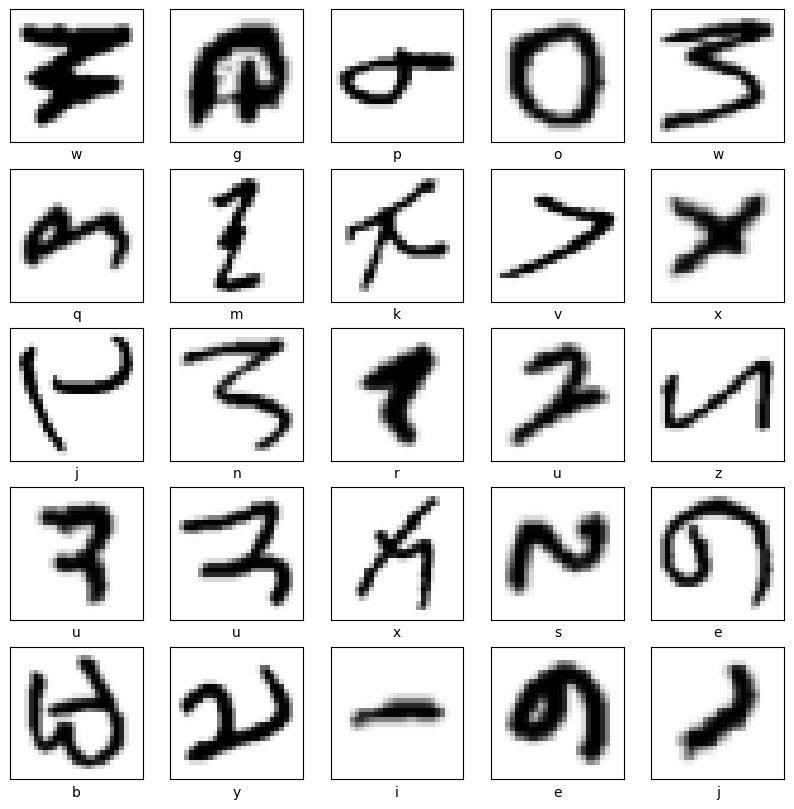

In [6]:
def show_emnist_samples(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(chr(labels[i] + 96))  # Convert labels to letters
    plt.show()

show_emnist_samples(train_images_emnist, train_labels_emnist)

## Step 8: Data Preprocessing for EMNIST
Before training the model, we need to preprocess the data, including normalization and one-hot encoding for the labels.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize data
train_images_emnist = train_images_emnist.astype('float32') / 255.
test_images_emnist = test_images_emnist.astype('float32') / 255.

# Add channel dimension
train_images_emnist = np.expand_dims(train_images_emnist, -1)
test_images_emnist = np.expand_dims(test_images_emnist, -1)

# One-hot encode the labels
num_classes = 26  # Number of letters in the alphabet
train_labels_emnist = tf.keras.utils.to_categorical(train_labels_emnist - 1, num_classes)
test_labels_emnist = tf.keras.utils.to_categorical(test_labels_emnist - 1, num_classes)

# Definisi generator dengan augmentasi
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Step 9: Class Distribution
We will visualize the class distribution to ensure a balanced dataset.

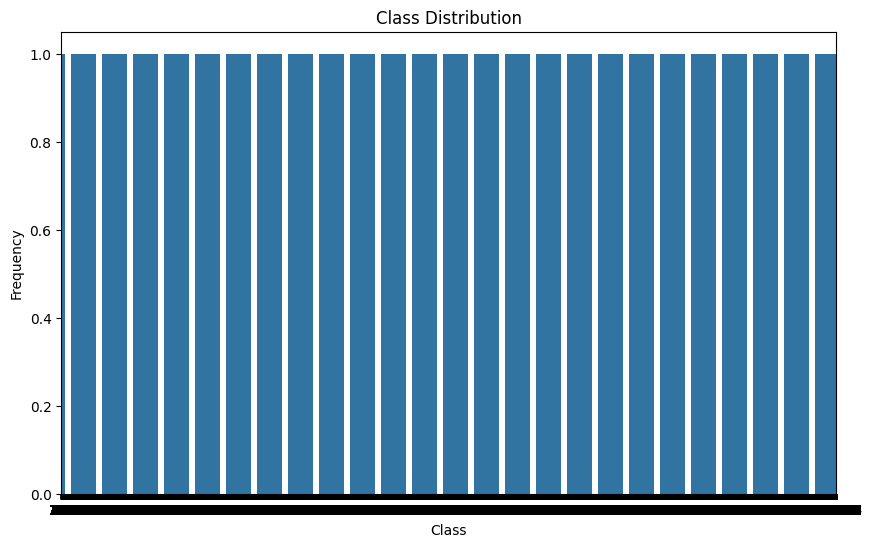

In [10]:
def plot_class_distribution(labels):
    plt.figure(figsize=(10, 6))
    sns.countplot(labels)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

plot_class_distribution(train_labels_emnist.argmax(axis=1))

## Step 10: Building the Model
We will build a CNN model using Keras.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 243,610 (951.60 KB)

 Trainable params: 243,610 (951.60 KB)

 Non-trainable params: 0 (0.00 B)

## Step 11: Training the Model
We will train the model using the training data and validate it using the test data.

In [9]:
# Training model dengan augmentasi data
history = model.fit(datagen.flow(train_images_emnist, train_labels_emnist, batch_size=32),
                    epochs=10,
                    validation_data=(test_images_emnist, test_labels_emnist))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3900/3900 ━━━━━━━━━━━━━━━━━━━━ 71s 16ms/step - accuracy: 0.4581 - loss: 1.7449 - val_accuracy: 0.8409 - val_loss: 0.4621
Epoch 2/10
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 68s 14ms/step - accuracy: 0.7518 - loss: 0.7661 - val_accuracy: 0.8780 - val_loss: 0.3662
Epoch 3/10
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 55s 14ms/step - accuracy: 0.7965 - loss: 0.6366 - val_accuracy: 0.8785 - val_loss: 0.3539
Epoch 4/10
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - accuracy: 0.8163 - loss: 0.5695 - val_accuracy: 0.8801 - val_loss: 0.3625
Epoch 5/10
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 85s 14ms/step - accuracy: 0.8289 - loss: 0.5297 - val_accuracy: 0.8824 - val_loss: 0.3538
Epoch 6/10
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 52s 13ms/step - accuracy: 0.8403 - loss: 0.4989 - val_accuracy: 0.8956 - val_loss: 0.3113
Epoch 7/10
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - accuracy: 0.8450 - loss: 0.4823 - val_accuracy: 0.8973 - val_loss: 0.3069
Epoch 8/10
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - accuracy: 0.8515 - loss: 0.46

## Step 12: Evaluating the Model
We will evaluate the model using the test data and display the results.

In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images_emnist, test_labels_emnist)
print(f"Test accuracy: {test_acc}")

# Predict using the model
predictions = model.predict(test_images_emnist)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels_emnist, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8938 - loss: 0.3314
Test accuracy: 0.9005769491195679
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Precision: 0.9035641753924742
Recall: 0.900576923076923
F1 Score: 0.9007650697737014


## Step 13: Visualizing the Training Process
We will visualize the accuracy and loss during training.

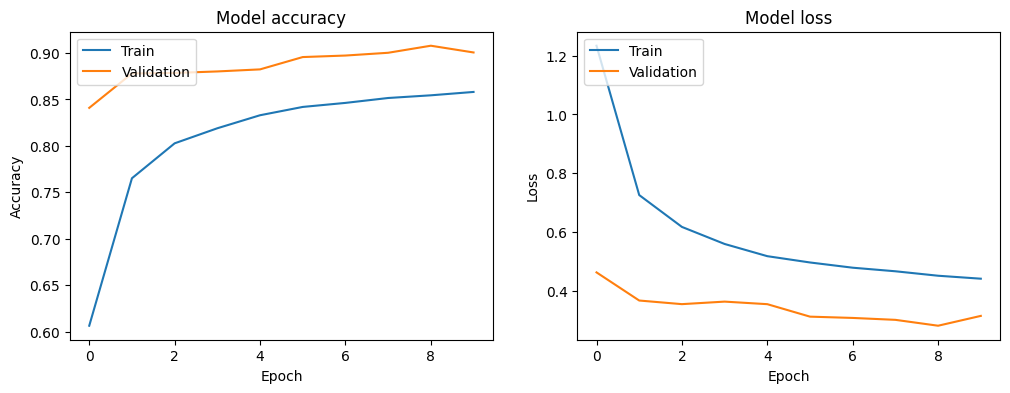

In [11]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Step 14: Confusion Matrix
We will visualize the confusion matrix to analyze the model's performance on individual classes.

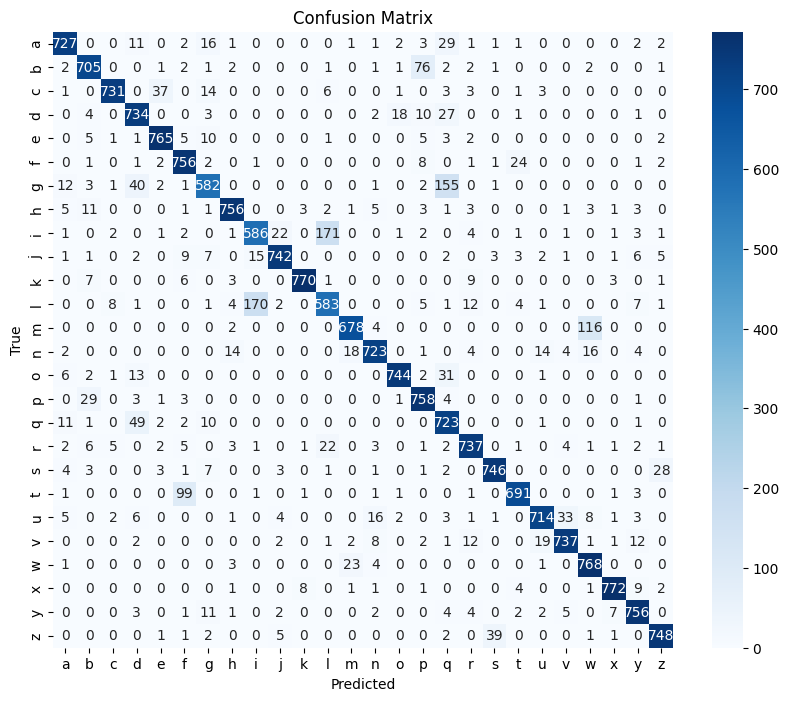

In [12]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[chr(i + 97) for i in range(26)], yticklabels=[chr(i + 97) for i in range(26)])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_true, y_pred)

## Step 15: Saving the Model
We will save the trained model for future use.

In [13]:
# Define paths
drive_dir = '/content/drive/MyDrive/Colab-Notebooks/LexiLearn_Machine_Learning'
processed_data_dir = os.path.join(drive_dir, 'data', 'processed')

# Save model in Keras native format
model.save(os.path.join(processed_data_dir, 'emnist_letters_model.keras'))

## Step 16: Loading and Testing the Model
We will load the saved model and perform predictions to test the model.

650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


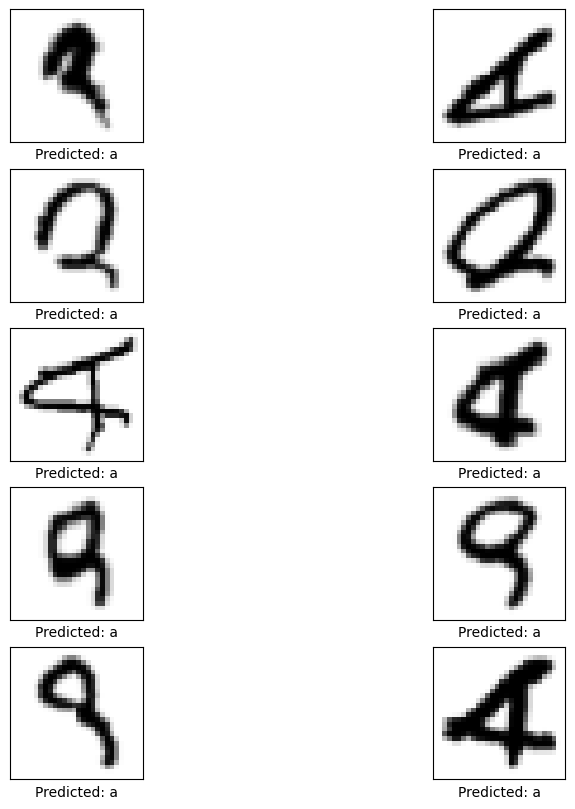

In [14]:
# Load the saved model
loaded_model = tf.keras.models.load_model(os.path.join(processed_data_dir, 'emnist_letters_model.h5'))

# Compile the loaded model with the same settings used during training
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Predict on the test set
predictions = loaded_model.predict(test_images_emnist)

# Display the first 10 test images and their predicted labels
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images_emnist[i], cmap=plt.cm.binary)
    predicted_label = chr(np.argmax(predictions[i]) + 97)  # Convert index to corresponding letter
    plt.xlabel(f"Predicted: {predicted_label}")
plt.show()

## Step 17: Model Predictions with Uploaded Image
We will upload an image and make a prediction.

Saving Screenshot 2024-06-21 at 10.07.44.png to Screenshot 2024-06-21 at 10.07.44 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


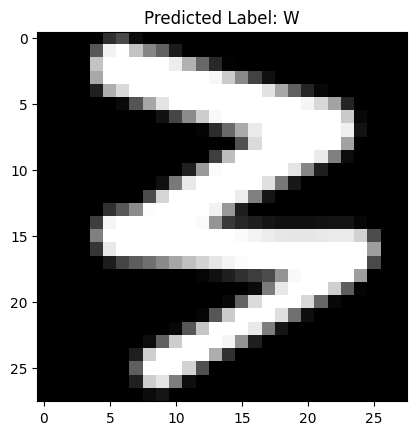

In [17]:
from google.colab import files
from PIL import Image

# Function to preprocess the uploaded image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((28, 28))  # Resize to 28x28 pixels
    img = np.array(img)
    img = img.astype('float32') / 255.  # Normalize pixel values
    img = np.expand_dims(img, axis=-1)  # Add batch dimension
    img = np.expand_dims(img, axis=0)   # Add channel dimension for grayscale
    return img

# Upload an image
uploaded = files.upload()

for fn in uploaded.keys():
    # Preprocess the image
    img = preprocess_image(fn)

    # Predict the letter
    prediction = loaded_model.predict(img)
    predicted_index = np.argmax(prediction)  # Get the index of the highest probability
    predicted_label = chr(predicted_index + 65)  # Convert index to corresponding letter (A-Z)

    # Display the image and prediction
    plt.imshow(img[0, :, :, 0], cmap=plt.cm.binary)
    plt.title(f'Predicted Label: {predicted_label}')
    plt.show()

## Step 18: Convert Model to TFLite Format
In this step, we will convert the trained Keras model into TensorFlow Lite `TFLite` format. TFLite models are optimized for mobile and embedded device deployment, making them suitable for running on Android devices. We will also save the converted TFLite model to a file and upload it to Google Drive for easy access and download.

In [ ]:
import tensorflow as tf
import os

# Define paths
project_dir = '/content/drive/MyDrive/Colab-Notebooks/LexiLearn_Machine_Learning'
processed_data_dir = os.path.join(project_dir, 'data', 'processed')
model_path = os.path.join(processed_data_dir, 'emnist_letters_model.h5')
tflite_model_path = os.path.join(processed_data_dir, 'converted_model.tflite')

# Load the trained model
loaded_model = tf.keras.models.load_model(model_path)

# Compile the loaded model with the same settings used during training
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the TFLite model to a file
os.makedirs(processed_data_dir, exist_ok=True)  # Create directory if it doesn't exist
tflite_model_path = os.path.join(processed_data_dir, 'converted_model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")

## Step 19: Convert Model to TFJS Format (optional)
In this step, we will convert the trained Keras model to TensorFlow.js format. This will save the model in a folder with `.json` and `.bin` files which can be used in web applications.

In [6]:
import tensorflow as tf
import tensorflowjs as tfjs
import os

# Define paths
project_dir = '/content/drive/MyDrive/Colab-Notebooks/LexiLearn_Machine_Learning'
processed_data_dir = os.path.join(project_dir, 'data', 'processed')
model_path = os.path.join(processed_data_dir, 'emnist_letters_model.h5')

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Define the path for the TFJS model
tfjs_model_dir = os.path.join(processed_data_dir, 'tfjs_model')

# Convert the model to TensorFlow.js format
tfjs.converters.save_keras_model(model, tfjs_model_dir)

print(f"TFJS model saved to: {tfjs_model_dir}")

# List the contents of the TFJS model directory to verify the conversion
print(os.listdir(tfjs_model_dir))

failed to lookup keras version from the file,
    this is likely a weight only file
TFJS model saved to: /content/drive/MyDrive/Colab-Notebooks/LexiLearn_Machine_Learning/data/processed/tfjs_model
['group1-shard1of1.bin', 'model.json']
